In [13]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """  
    
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    left_lines = []
    right_lines = []
    top_y = 1e6
    top_x = 0
    slope = 0

    
    # Go thru all the lines and separate Left and Right lines
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 != x2:
                slope = (y2-y1) / (x2-x1)
                if slope > 0:
                    left_lines.append([x1,y1,x2,y2])        
                else:
                    right_lines.append([x1,y1,x2,y2])
            if top_y > y1:
                top_y = y1
            if top_y > y2:
                top_y = y2

    #Left side line
    if len(left_lines) > 0:
        left_line = [0, 0, 0, 0]
        for line in left_lines:
            assert(len(line) == 4)
            for i in range(4):
                left_line[i] += (line[i] / len(left_lines))
                
        slope = (left_line[3] - left_line[1]) / (left_line[2] - left_line[0])
        top_x = int (left_line[0] + (top_y - left_line[1]) / slope)
        bottom_x = int (left_line[0] + (img.shape[0] - left_line[1]) / slope)
        #Draw left side line
        cv2.line(img, (bottom_x, img.shape[0]), (top_x, top_y), color, thickness)

    #Right side line
    if len(right_lines) > 0:
        right_line = [0, 0, 0, 0]
        for line in right_lines:
            assert(len(line) == 4)
            for i in range(4):
                right_line[i] += (line[i] / len(right_lines))
        slope = (right_line[3] - right_line[1]) / (right_line[2] - right_line[0])
        top_x = int (right_line[0] + (top_y - right_line[1]) / slope)
        bottom_x = int (right_line[0] + (img.shape[0] - right_line[1]) / slope)
        #Draw right side line
        cv2.line(img, (bottom_x, img.shape[0]), (top_x, top_y), color, thickness)
        

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=10)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # turn to gray image
    gray = grayscale(image)

    # Create a Blur image
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Edge detect with Canny
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Create a polygon coordinates
    left_bottom = [120, 540]
    right_bottom = [900, 540]
    apex = [485, 310]
    left_top = [440, 330]
    right_top = [540, 330]
    
    # Create vertices provided by a coordinates of polygon
    vertices = np.array( [[left_top, right_top, right_bottom, left_bottom]], dtype=np.int32 )
    
    # Select the region as based on the vertices
    masked_edges = region_of_interest(edges, vertices)
    
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_length = 100
    max_line_gap = 160
    
    
    line_image = np.copy(image)*0

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold,
                            min_line_length, max_line_gap)
    
    result = weighted_img(line_img, image)
    
    return result


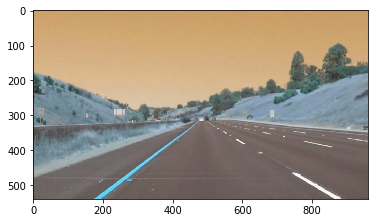

In [17]:
import os
os.listdir("test_images/")
image = cv2.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(image, cmap='gray')
plt.show()

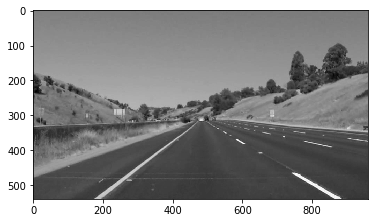

In [18]:
gray = grayscale(image)
plt.imshow(gray, cmap='gray')
plt.show()

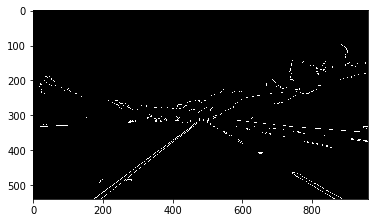

In [19]:
low_threshold = 150
high_threshold = 255
edges = canny(gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')
plt.show()

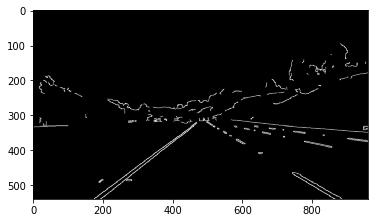

In [20]:
kernel_size = 5
blur_gray = gaussian_blur(edges, kernel_size)
plt.imshow(blur_gray, cmap='gray')
plt.show()

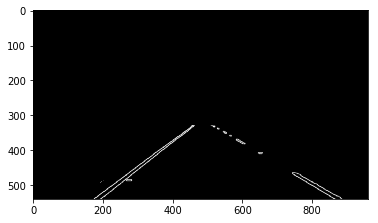

In [21]:
left_bottom = [120, 540]
right_bottom = [900, 540]
apex = [485, 310]
#apex = [480, 290]
left_top = [440, 330]
right_top = [540, 330]
#vertices = np.array( [[left_bottom, right_bottom, apex]], dtype=np.int32 )
vertices = np.array( [[left_top, right_top, right_bottom, left_bottom]], dtype=np.int32 )
masked_image = region_of_interest(blur_gray, vertices)
plt.imshow(masked_image, cmap='gray')
plt.show()

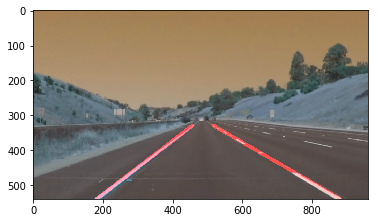

In [22]:
final_image = process_image(image)
plt.imshow(final_image, cmap='gray')
plt.show()

In [23]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")

challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip("test_videos/challenge.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

yellow_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 84.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.27 s, sys: 630 ms, total: 2.9 s
Wall time: 3.05 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:08<00:00, 81.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.27 s, sys: 1.81 s, total: 9.08 s
Wall time: 8.81 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|██████████| 251/251 [00:07<00:00, 33.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 5.99 s, sys: 1.72 s, total: 7.71 s
Wall time: 8.77 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))